# UC Merced Land Use - Transfer Learning with GoogLeNet

## Import Libraries

In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=0a91471d582d9b909da52f233d3efdad145bd64f56d3a382279b48db2eb66e82
  Stored in directory: /root/.cache/pip/wheels/18/0c/ac/81bacd5a53085ac633beb52c80c08152db65a81e93b15b392d
Successfully built torchviz


In [24]:
import os 
import random
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchviz import make_dot
import optuna

In [3]:
# import shutil
# shutil.rmtree('/kaggle/working/')

## Prepare Dataset

### Split into Train, Validation and Test Sets

In [4]:
test_size = 0.15
val_size = 0.15

In [5]:
data_dir = '/kaggle/input/ucmerced-landuse/UCMerced_LandUse/Images'
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)
    
classes = os.listdir(data_dir)

for clss in classes:
    clss_path = os.path.join(data_dir, clss)
    images = os.listdir(clss_path)
    train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
    train_images, val_images = train_test_split(train_images, test_size=val_size/(1-test_size), random_state=42)
    
    for train_image in train_images:
        src = os.path.join(clss_path, train_image)
        dst = os.path.join(train_dir, clss)
        if not os.path.exists(dst):
            os.makedirs(dst)
        shutil.copy(src, os.path.join(dst, train_image))
        
    for val_image in val_images:
        src = os.path.join(clss_path, val_image)
        dst = os.path.join(val_dir, clss)
        if not os.path.exists(dst):
            os.makedirs(dst)
        shutil.copy(src, os.path.join(dst, val_image))
        
    for test_image in test_images:
        src = os.path.join(clss_path, test_image)
        dst = os.path.join(test_dir, clss)
        if not os.path.exists(dst):
            os.makedirs(dst)
        shutil.copy(src, os.path.join(dst, test_image))
    

### Apply Transforms

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(10),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=data_transforms['val'])

### Create Dataloaders

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [8]:
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

In [9]:
dataset_sizes = {
    'train': len(train_dataset), 
    'val': len(val_dataset),
    'test': len(test_dataset)
}

print(dataset_sizes)

{'train': 1449, 'val': 336, 'test': 315}


In [10]:
class_names = train_dataset.classes
num_classes = len(class_names)

## Optimize Parameters

### Setup Device

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Define Objective Function

In [12]:
num_epochs = 10

In [13]:
def objective(trial):
    # load pre-trained GoogLeNet model
    model = models.googlenet(pretrained=True)
    model.to(device)
    
    # replace last layer to match the number of classes in UC Merced dataset
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.to(device)
    
    # set hyperparameters for Optuna
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)
    momentum = trial.suggest_float('momentum', 0.5, 0.999)
    step_size = trial.suggest_int('step_size', 1, 30)
    gamma = trial.suggest_float('gamma', 0.1, 1.0)
    num_epochs = trial.suggest_int('num_epochs', 5, 50)
    
    # set optimizer and loss function
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, 
                          weight_decay=weight_decay, momentum=momentum)
    criterion = nn.CrossEntropyLoss()
    
    # create learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, 
                                         gamma=gamma)
    
    for epoch in range(num_epochs):
        print(epoch)
        model.train()
        running_loss = 0.0
        for train_images, train_labels in train_loader: 
            train_images, train_labels = train_images.to(device), train_labels.to(device)
            optimizer.zero_grad()
            train_predictions = model(train_images)
            loss = criterion(train_predictions, train_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # update learning rate
        scheduler.step()
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_predictions = model(val_images)
                loss = criterion(val_predictions, val_labels)
                val_loss += loss.item()
                _, predicted = torch.max(val_predictions.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()
                
        trial.report(val_loss/len(val_loader), epoch)
        if trial.should_prune(): 
            raise optuna.exceptions.TrialPruned()
    return val_loss/len(val_loader)

### Find Best Hyperparameters

In [14]:
# study = optuna.create_study(direction='minimize', 
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
# study.optimize(objective, n_trials=10, timeout=7200)

### Print Found Hyperparameters

In [15]:
# best_params = study.best_params
# print(f'Best hyperparameters: {best_params}')

## Train Model w/ Found Hyperparameters

In [16]:
best_params =  {'lr': 0.0074391316898536905, 
'weight_decay': 0.0008783418521336298, 
'momentum': 0.7426637487499734, 
'step_size': 23, 
'gamma': 0.5136244681640415, 
'num_epochs': 32}

In [17]:
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

optimizer = optim.SGD(
            model.parameters(), 
            lr = best_params['lr'], 
            weight_decay = best_params['weight_decay'], 
            momentum = best_params['momentum']
)

scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                     step_size = best_params['gamma'])

criterion = nn.CrossEntropyLoss()

num_epochs = num_epochs
patience = 3

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

early_stop_counter = 0
best_val_loss = float('inf')

start = time.time()
for epoch in range(num_epochs):
        # train
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        for train_images, train_labels in train_loader: 
            train_images, train_labels = train_images.to(device), train_labels.to(device)
            
            optimizer.zero_grad()
            
            train_predictions = model(train_images)
            loss = criterion(train_predictions, train_labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, train_predicted = torch.max(train_predictions.data, 1)
            train_total += train_labels.size(0)
            train_correct += (train_predicted == train_labels).sum().item()
            
        train_loss = running_loss/len(train_loader)
        train_accuracy = train_correct/train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
               
            val_predictions = model(val_images)
            loss = criterion(val_predictions, val_labels)
            val_loss += loss.item()
                
            _, val_predicted = torch.max(val_predictions.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
                
        val_loss = val_loss/len(val_loader)
        val_accuracy = val_correct/val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # update learning rate based on validation loss
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
#         # early stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             early_stop_counter = 0
#         else:
#             early_stop_counter += 1
#             if early_stop_counter >= patience:
#                 print("Early stopping triggered")
#                 break

end = time.time()
        
print("Execution time: {:.2f} seconds".format(round(end - start, 2)))

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

5621429
Epoch 1/10, Train Loss: 2.3970, Val Loss: 0.1496, Train Acc: 0.4127, Val Acc: 0.8750


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/10, Train Loss: 1.0425, Val Loss: 0.0220, Train Acc: 0.8233, Val Acc: 0.9375
Epoch 3/10, Train Loss: 0.4940, Val Loss: 0.0198, Train Acc: 0.9220, Val Acc: 0.9375
Epoch 4/10, Train Loss: 0.2950, Val Loss: 0.0171, Train Acc: 0.9462, Val Acc: 0.9375
Epoch 5/10, Train Loss: 0.1984, Val Loss: 0.0138, Train Acc: 0.9676, Val Acc: 0.9375
Epoch 6/10, Train Loss: 0.1644, Val Loss: 0.0116, Train Acc: 0.9738, Val Acc: 0.9375
Epoch 7/10, Train Loss: 0.1193, Val Loss: 0.0141, Train Acc: 0.9779, Val Acc: 0.9375
Epoch 8/10, Train Loss: 0.0895, Val Loss: 0.0103, Train Acc: 0.9862, Val Acc: 0.9375
Epoch 9/10, Train Loss: 0.0764, Val Loss: 0.0119, Train Acc: 0.9855, Val Acc: 0.9375
Epoch 10/10, Train Loss: 0.0662, Val Loss: 0.0060, Train Acc: 0.9890, Val Acc: 1.0000
Execution time: 76.85 seconds


In [18]:
# Forward pass through the model
output = model(train_images)

# Generate the computation graph of the model
graph = make_dot(output, params=dict(model.named_parameters()))

# Save the graph visualization to a file
graph.render("model_googlenet")

'model_googlenet.pdf'

## Results


### Learning Curves

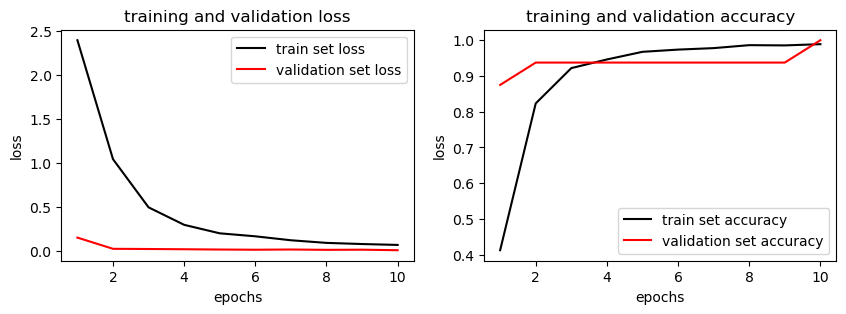

In [19]:
epochs = range(1, len(val_losses) + 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
 
ax[0].plot(epochs, train_losses, label="train set loss", color="k")
ax[0].plot(epochs, val_losses, label="validation set loss", color="r")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].set_title("training and validation loss")
ax[0].legend()

ax[1].plot(epochs, train_accuracies, label="train set accuracy", color="k")
ax[1].plot(epochs, val_accuracies, label="validation set accuracy", color="r")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")
ax[1].set_title("training and validation accuracy")
ax[1].legend()
fig.savefig(f"googlenet_{1-(val_size+test_size)}_{len(epochs)}e_learning_curves.jpg")

### Accuracy

In [20]:
model.eval()

test_loss = 0.0
test_correct = 0 
test_total = 0

start = time.time()

with torch.no_grad(): 
    for test_images, test_labels in test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        
        test_predictions = model(test_images)
        loss = criterion(test_predictions, test_labels)
        test_loss += loss.item()
        
        _, test_predicted = torch.max(test_predictions.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()
        
test_loss = test_loss/len(test_loader)
test_accuracy = test_correct/test_total

end = time.time()

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Execution time: {round(end - start, 2):.2f} seconds")

Test Loss: 0.0743, Test Accuracy: 0.9841, Execution time: 0.87 seconds


### Confusion Matrix

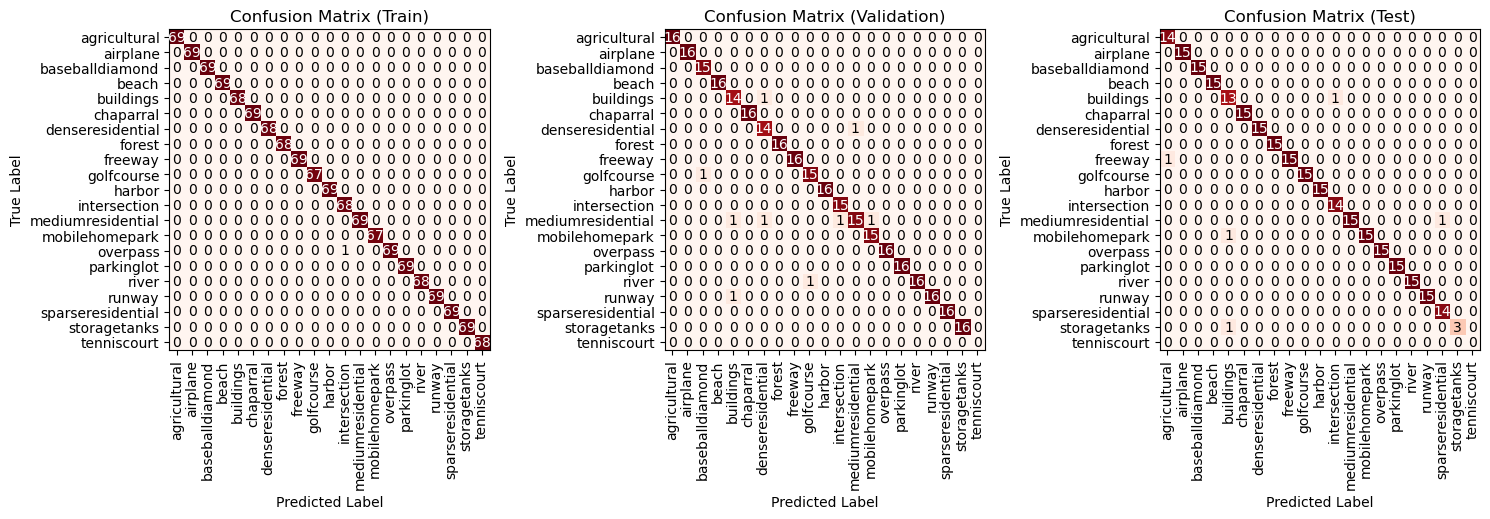

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Train confusion matrix
cm = torch.zeros(num_classes, num_classes)

model.eval()
with torch.no_grad():
    for train_images, train_labels in train_loader:
        train_images, train_labels = train_images.to(device), train_labels.to(device)
    
        train_predictions = model(train_images)
        _, train_predicted = torch.max(train_predictions, 1)
        
        if len(train_predictions) != 32:
            continue
        
        for i in range(len(train_labels)):
            cm[train_predicted[i], train_labels[i]] += 1
        
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axs[0].text(j, i, int(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
        
axs[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
axs[0].set_xticks(np.arange(num_classes))
axs[0].set_yticks(np.arange(num_classes))
axs[0].set_xticklabels(class_names, rotation=90)
axs[0].set_yticklabels(class_names)
axs[0].set_xlabel('Predicted Label')
axs[0].set_ylabel('True Label')
axs[0].set_title('Confusion Matrix (Train)')

# Validation confusion matrix
cm = torch.zeros(num_classes, num_classes)

model.eval()
with torch.no_grad():
    for val_images, val_labels in val_loader:
        val_images, val_labels = val_images.to(device), val_labels.to(device)
    
        val_predictions = model(val_images)
        _, val_predicted = torch.max(val_predictions, 1)
        
        if len(val_predictions) != 32:
            continue
        
        for i in range(len(val_labels)):
            cm[val_predicted[i], val_labels[i]] += 1

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axs[1].text(j, i, int(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

axs[1].imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
axs[1].set_xticks(np.arange(num_classes))
axs[1].set_yticks(np.arange(num_classes))
axs[1].set_xticklabels(class_names, rotation=90)
axs[1].set_yticklabels(class_names)
axs[1].set_xlabel('Predicted Label')
axs[1].set_ylabel('True Label')
axs[1].set_title('Confusion Matrix (Validation)')

# Test confusion matrix
cm = torch.zeros(num_classes, num_classes)

model.eval()
with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
    
        test_predictions = model(test_images)
        _, test_predicted = torch.max(test_predictions, 1)
        
        if len(test_predictions) != 32:
            continue
        
        for i in range(len(test_labels)):
            cm[test_predicted[i], test_labels[i]] += 1
        
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
            axs[2].text(j, i, int(cm[i, j]),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black")
    
axs[2].imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
axs[2].set_xticks(np.arange(num_classes))
axs[2].set_yticks(np.arange(num_classes))
axs[2].set_xticklabels(class_names, rotation=90)
axs[2].set_yticklabels(class_names)
axs[2].set_xlabel('Predicted Label')
axs[2].set_ylabel('True Label')
axs[2].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.savefig(f"googlenet_{1-(val_size+test_size)}_{len(epochs)}e_confusion_matrix.jpg")
plt.show()